# Importing Libraries

In [ ]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Disclaimer

All of the survivors are from the Star Wars EU, which was made not canon when Disney took over. However, there is so much interesting lore that I found it a disservice not to include these people.

In [ ]:
data_path = '/content/Order_66_Survivors.xlsx'
df = pd.read_excel(data_path)

In [ ]:
df

,Name,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,Yoda,Yes,Male,900,Unknown,Grand Master,Green,Hazel,Gray,Single blade,Ataru,Green,1
1,Jocasta Nu,Yes,Female,91,Human,Master,Blue,Blue,Silver,Single blade,Ataru,Light,1
2,Obi-Wan Kenobi,Yes,Male,57,Human,Master,Blue,Blue-Gray,White,Single blade,Soresu,Fair,1
3,Kelleran Beq,Yes,Male,Unknown,Human,Master,Green,Brown,Black,Single blade,Unknown,Dark,0
4,Cal Kestis,Yes,Male,23,Human,Knight,Blue,Green,Red,Split blade,Shii-Cho,Light,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Unidentified Reptilian Jedi Knight,Yes,Male,Unknown,Unknown,Knight,Unknown,Silver,None,Unknown,Unknown,Orange,1
95,Sarn Vals,No,Male,Unknown,Quarren,Knight,Unknown,Unknown,None,Unknown,Unknown,Unknown,0
96,Rae Vixe,No,Male,Unknown,Gran,Master,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,0
97,Arligan Zey,Yes,Male,Unknown,Human,Master,Unknown,Blue,Dark Brown,Unknown,Unknown,Unknown,0


In [ ]:
df.isnull().sum()

Name                            0
Remained_Jedi?                  0
Gender                          0
Age                             0
Species                         0
Rank                            0
Lightsaber_Color                0
Eye_Color                       0
Hair_Color                      0
Lightsaber_Type                 0
Lightsaber_Form                 0
Skin_Color                      0
Alive_After_Battle_of_Yavin?    0
dtype: int64

# Eyeballing the Data

In [ ]:
rank_counts = df.groupby("Rank")["Name"].count()
rank_counts

Rank
Grand Master     1
Initiate         5
Knight          24
Master          30
Padawan         13
Temple Guard     1
Unknown         24
Youngling        1
Name: Name, dtype: int64

Looks like Jedi Masters and Jedi Knights survived much more than the younger Jedi.

In [ ]:
survivors = df.groupby("Alive_After_Battle_of_Yavin?")["Name"].count()
survivors

Alive_After_Battle_of_Yavin?
0    42
1    57
Name: Name, dtype: int64

Sad to see that more than half of the Jedi were slain after Order 66 (zero meaning true and one meaning false).

In [ ]:
df.dtypes

Name                            object
Remained_Jedi?                  object
Gender                          object
Age                             object
Species                         object
Rank                            object
Lightsaber_Color                object
Eye_Color                       object
Hair_Color                      object
Lightsaber_Type                 object
Lightsaber_Form                 object
Skin_Color                      object
Alive_After_Battle_of_Yavin?     int64
dtype: object

In [ ]:
df.head()

,Name,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,Yoda,Yes,Male,900,Unknown,Grand Master,Green,Hazel,Gray,Single blade,Ataru,Green,1
1,Jocasta Nu,Yes,Female,91,Human,Master,Blue,Blue,Silver,Single blade,Ataru,Light,1
2,Obi-Wan Kenobi,Yes,Male,57,Human,Master,Blue,Blue-Gray,White,Single blade,Soresu,Fair,1
3,Kelleran Beq,Yes,Male,Unknown,Human,Master,Green,Brown,Black,Single blade,Unknown,Dark,0
4,Cal Kestis,Yes,Male,23,Human,Knight,Blue,Green,Red,Split blade,Shii-Cho,Light,0


In [ ]:
df['Remained_Jedi?'].value_counts()

No      49
Yes     48
Yes      1
No       1
Name: Remained_Jedi?, dtype: int64

Maybe worth investigating why there are two yes's and two no's. There is no difference in my Excel sheet that shows these differences.

In [ ]:
df['Gender'].value_counts()

Male      69
Female    30
Name: Gender, dtype: int64

There are two times more male Order 66 survivors compared to female survivors.

In [ ]:
df['Age'].value_counts()

Unknown    73
40          3
22          2
24          2
900         1
55          1
34          1
184         1
36          1
28          1
50          1
97          1
26          1
47          1
91          1
43          1
32          1
39          1
38          1
174         1
23          1
57          1
52          1
Name: Age, dtype: int64

Might look into dropping the age column, as most of these survivors have an unknown age. I already forsee it causing me a headache when creating dummy variables.

In [ ]:
df['Species'].value_counts()

Human                     45
Unknown                   13
Zabrak                     5
Humanoid                   4
Kadas'sa'Nikto             2
Togruta                    2
Twi'lek                    2
Mirialan                   2
Aleena                     1
Whipid                     1
Human                      1
Lannik                     1
Miraluka                   1
Ithorian                   1
Ishi Tib                   1
Barolian                   1
Abyssin                    1
Quarren                    1
Devaronian                 1
Terrelian Jango Jumper     1
Cerean                     1
Near-Human                 1
Iktotchi                   1
Wookie                     1
Dowutin                    1
Pkorian                    1
Arkanian Offshoot          1
Pau'an                     1
Ongree                     1
Kiffar                     1
Thisspiasian               1
Gran                       1
Name: Species, dtype: int64

Humans are the MOST common species. Was this favoritism by George Lucas or do humans have a more natural affinity to force sensitivity?

In [ ]:
df['Rank'].value_counts()

Master          30
Knight          24
Unknown         24
Padawan         13
Initiate         5
Grand Master     1
Temple Guard     1
Youngling        1
Name: Rank, dtype: int64

In [ ]:
df['Lightsaber_Color'].value_counts()

Red            30
Unknown        25
Green          19
Blue           15
Yellow          3
None            1
White           1
Bright blue     1
Purple          1
Violet          1
Orange          1
Blue-Green      1
Name: Lightsaber_Color, dtype: int64

Red dominates the lightsaber colors, signifying that many Jedi succumbed to the Dark Side after Order 66.

In [ ]:
df['Eye_Color'].value_counts()

Unknown          22
Brown            21
Blue             19
Green             7
Yellow            7
Black             4
Purple            2
Hazel             1
Light             1
Silver            1
Red               1
None              1
Yellow-Orange     1
Blue & Orange     1
Light mint        1
Orange            1
Red               1
Blue-Green        1
White             1
Ice-Blue          1
Gray              1
Teal              1
Blue-Gray         1
Pale Blue         1
Name: Eye_Color, dtype: int64

Blue and brown eyes are the most common, no competition.

In [ ]:
df['Hair_Color'].value_counts()

None           20
Unknown        16
Black          15
Brown          11
White          11
Gray            6
Red             3
Dark Brown      3
Blonde          3
Auburn          2
Dark            2
Silver-Gray     1
Silver          1
Blue            1
Pink            1
Light Brown     1
Dark-blue       1
Dark            1
Name: Hair_Color, dtype: int64

Surprisingly, a lot of people were either bald or their species didn't have hair.

In [ ]:
df['Lightsaber_Type'].value_counts()

Single blade     46
Unknown          26
Double bladed    16
Dual wield        5
Split blade       3
None              1
Pike              1
Staff             1
Name: Lightsaber_Type, dtype: int64

Even in the shows and movies, single bladed lightsabers were the most commonly used, so it makes sense that these are the most used.

In [ ]:
df['Lightsaber_Form'].value_counts()

Unknown          71
Ataru             5
Niman             5
Shien/Djem So     5
Jar'Kai           3
Soresu            2
Shii-Cho          2
Juyo              2
None              1
Makashi           1
Shien             1
Makashi/Ataru     1
Name: Lightsaber_Form, dtype: int64

Unfortunately, I could not find much info on the forms used by the survivors.

In [ ]:
df['Skin_Color'].value_counts()

Unknown        18
Light          18
Fair           16
Tan             7
Green           6
Dark            5
Brown           5
Yellow          3
Pale            3
Red             3
White           3
Gray            2
Black           1
Blue            1
Light Tan       1
Dark Green      1
Black/Brown     1
Gray-Green      1
Blue-Gray       1
Dark Orange     1
Ashen White     1
Orange          1
Name: Skin_Color, dtype: int64

Light and fair skin are the top skin colors, which would come from the fact that humans survived the most from the purge.

# Preprocessing my Data

For a classification tree, all of the data must be converted to numerical data, so that is what this preprocessing is. I am dropping the Name column because each name is unique, so it would not add much value.

In [ ]:
# drop unnecessary columns
df.drop(['Name'], axis=1, inplace=True)
# convert Jedi status and gender variables to numerical
df['Remained_Jedi?'] = df['Remained_Jedi?'].apply(lambda x: 1 if x == 'No' else 0)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# Convert response from an integer to a categorical variable
df['Alive_After_Battle_of_Yavin?'] = df['Alive_After_Battle_of_Yavin?'].astype('category')
df.head()

,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,0,1,900,Unknown,Grand Master,Green,Hazel,Gray,Single blade,Ataru,Green,1
1,0,0,91,Human,Master,Blue,Blue,Silver,Single blade,Ataru,Light,1
2,0,1,57,Human,Master,Blue,Blue-Gray,White,Single blade,Soresu,Fair,1
3,0,1,Unknown,Human,Master,Green,Brown,Black,Single blade,Unknown,Dark,0
4,0,1,23,Human,Knight,Blue,Green,Red,Split blade,Shii-Cho,Light,0


In [ ]:
df.dtypes

Remained_Jedi?                     int64
Gender                             int64
Age                               object
Species                           object
Rank                              object
Lightsaber_Color                  object
Eye_Color                         object
Hair_Color                        object
Lightsaber_Type                   object
Lightsaber_Form                   object
Skin_Color                        object
Alive_After_Battle_of_Yavin?    category
dtype: object

It was easy to make the previous two columns into ones and zeros, but the other ones require a bit more work.

In [ ]:
# making categorical columns into numerical dummies
def dummyize(x, columns):
  for column in range(0, len(columns)):
      if x == columns[column]:
          return column

In [ ]:
# making dummies from categorical columns
df["Age"] = df["Age"].apply(lambda x: dummyize(x, pd.get_dummies(df['Age']).columns))
df["Species"] = df["Species"].apply(lambda x: dummyize(x, pd.get_dummies(df['Species']).columns))
df["Rank"] = df["Rank"].apply(lambda x: dummyize(x, pd.get_dummies(df['Rank']).columns))
df["Lightsaber_Color"] = df["Lightsaber_Color"].apply(lambda x: dummyize(x, pd.get_dummies(df['Lightsaber_Color']).columns))
df["Eye_Color"] = df["Eye_Color"].apply(lambda x: dummyize(x, pd.get_dummies(df['Eye_Color']).columns))
df["Hair_Color"] = df["Hair_Color"].apply(lambda x: dummyize(x, pd.get_dummies(df['Hair_Color']).columns))
df["Lightsaber_Type"] = df["Lightsaber_Type"].apply(lambda x: dummyize(x, pd.get_dummies(df['Lightsaber_Type']).columns))
df["Lightsaber_Form"] = df["Lightsaber_Form"].apply(lambda x: dummyize(x, pd.get_dummies(df['Lightsaber_Form']).columns))
df["Skin_Color"] = df["Skin_Color"].apply(lambda x: dummyize(x, pd.get_dummies(df['Skin_Color']).columns))

In [ ]:
df.head()

,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,0,1,21,28,0,3,8,9,4,0,12,1
1,0,0,17,8,3,0,1,14,4,0,13,1
2,0,1,16,8,3,0,3,17,4,10,9,1
3,0,1,22,8,3,3,5,1,4,11,6,0
4,0,1,1,8,2,0,7,13,5,9,13,0


While the code successfully turned all the different outputs into numbers, I have to manually go look at my Excel sheet and match up each number with the corresponding output. I have no clue what Eye_Color 8 is, so it's important to create a data dictionary of sorts.

In [ ]:
# Here I am saving these results to an Excel file so I can reference it for my data dictionary
df.to_excel('Preprocessed_Order_66_Data.xlsx', index=False)

# Split Data into Training & Testing Sets

We are looking at who survived and their attributes, so make sure that the Battle of Yavin column is not in the X columns and is the only one in the y column.

In [ ]:
# split the data into training and testing sets
X = df.drop(['Alive_After_Battle_of_Yavin?'], axis=1)

y = df['Alive_After_Battle_of_Yavin?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 94 to 51
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Remained_Jedi?    69 non-null     int64
 1   Gender            69 non-null     int64
 2   Age               69 non-null     int64
 3   Species           69 non-null     int64
 4   Rank              69 non-null     int64
 5   Lightsaber_Color  69 non-null     int64
 6   Eye_Color         69 non-null     int64
 7   Hair_Color        69 non-null     int64
 8   Lightsaber_Type   69 non-null     int64
 9   Lightsaber_Form   69 non-null     int64
 10  Skin_Color        69 non-null     int64
dtypes: int64(11)
memory usage: 6.5 KB
<class 'pandas.core.series.Series'>
Int64Index: 69 entries, 94 to 51
Series name: Alive_After_Battle_of_Yavin?
Non-Null Count  Dtype   
--------------  -----   
69 non-null     category
dtypes: category(1)
memory usage: 745.0 bytes


I originally used the default values, but it created a very small tree with not many options. I want my tree to show a variation of the attributes I researched, so I had to trial and error my min_samples_leaf to show the different attributes.

In [ ]:
# create an instance of a decision tree classifier using default values

dt = DecisionTreeClassifier(max_depth = 25, min_samples_leaf=5, ccp_alpha = 0.001)

# fit the model to the training data
dt.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.001, max_depth=25, min_samples_leaf=5)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")

'decision_tree_default.pdf'

# Here is my Tree!

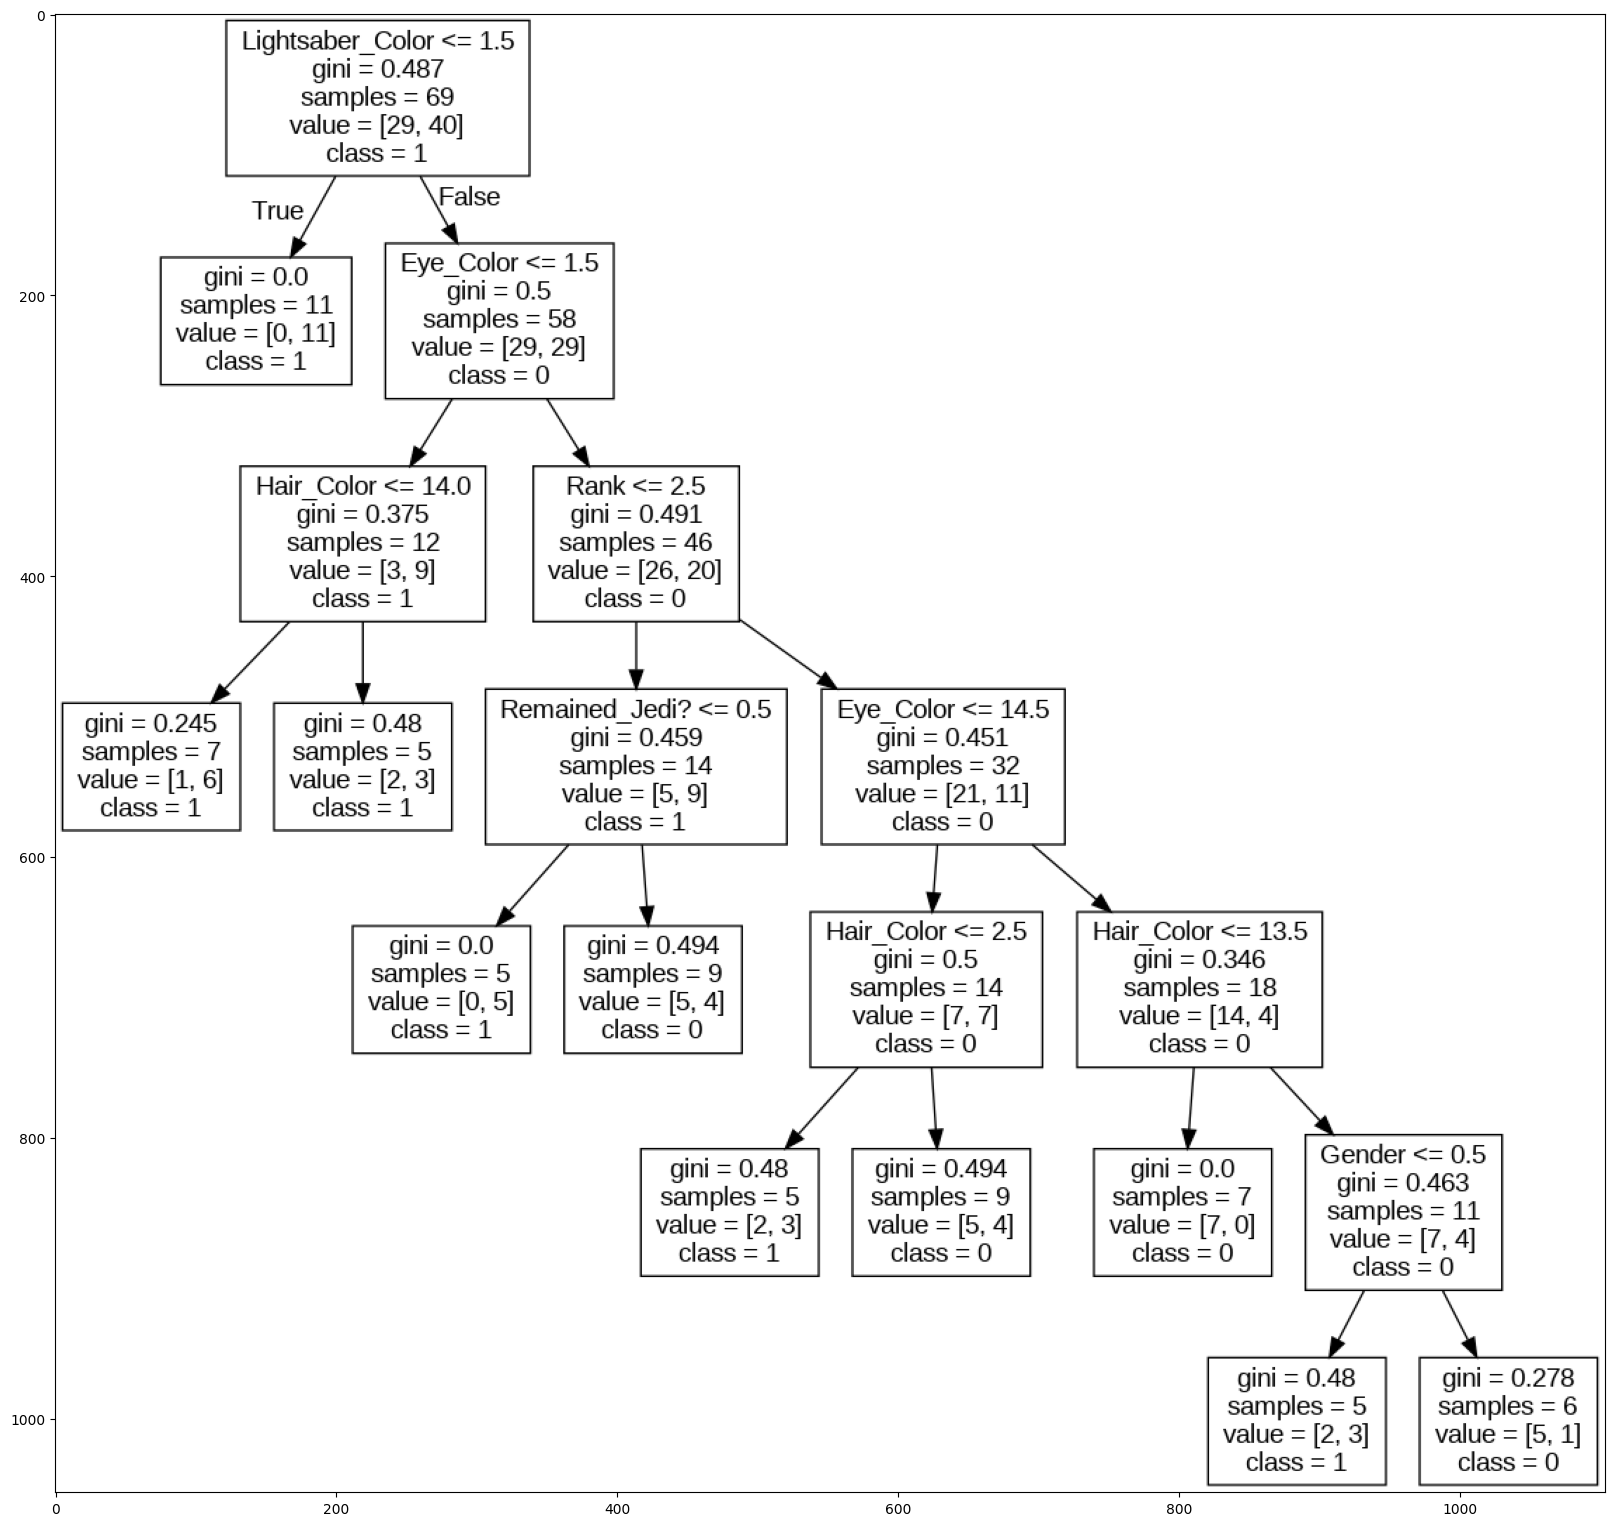

In [ ]:
export_graphviz(dt,
                'tree.dot',
                class_names=['0','1'],
                feature_names = X_train.columns)
! dot -Tpng tree.dot -o tree.png

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 40))
plt.imshow(img)

## Interpreting the Tree

As will be seen with the clusters, the tree can be confusing wihtout the dictionary that I have created. I will walk through the best survival choice, which is the bottom right terminal node. I will work my way up the tree, or backwards, so keep that in mind. Alright, time to find what traits lead to the best survival odds! One has a better chance of surviving if they are male, don't have red hair, don't have pale blue eyes, are ranked a greatly skilled Knight or higher, don't have blue eyes, and not have a blue lightsaber.

At the end of the day, this is not the most explanatory tree, but that is to be expected as luck played a key role in survival. You just had to be one of the lucky ones, as even the most skilled Masters were killed by the Empire.

# Making Predictions on the Sets

In [ ]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

# Assesing the Model

In [ ]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.7681
Precision: 0.8158
Recall.  : 0.7750

 -- test set -- 
Accuracy : 0.4333
Precision: 0.5000
Recall.  : 0.4118


While my training set was not bad, my testing set is not the best. This is due to my decreasing my minimum leaf samples, but this is the tradeoff I decided was necessary. When working with this specific type of data, keep in mind that it is not as conventional as, for example, data from a grocery store about customers.

# Confusion Matrix for Training & Testing Sets

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[22  9]
 [ 7 31]]
[[ 6 10]
 [ 7  7]]


# ROC Curve for Training & Testing

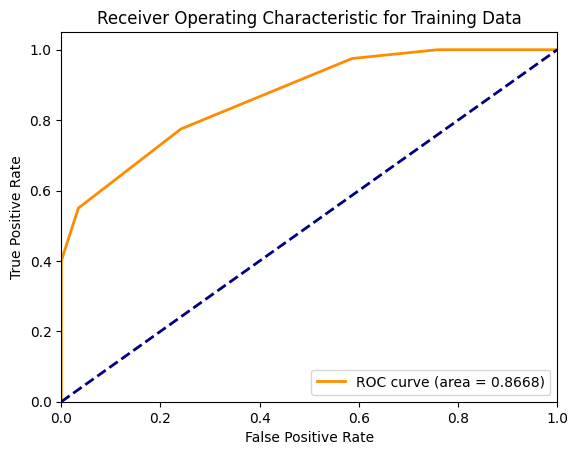

In [ ]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

The closer to one we are for the ROC Curve area, the better! And seeing as the training area is 0.86, this is pretty great.

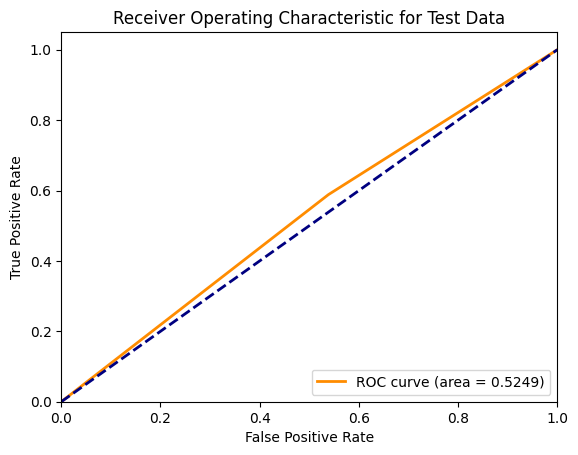

In [ ]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


Ok now, don't judge this curve too much (or do, that's your prerogative) but the area is not that great. Again, this is probably due to me decreasing the minimum leaf samples.

# Tree Importance

    importance           feature
5     0.326650  Lightsaber_Color
6     0.219495         Eye_Color
0     0.140188    Remained_Jedi?
4     0.123125              Rank
7     0.118176        Hair_Color
1     0.072368            Gender
2     0.000000               Age
3     0.000000           Species
8     0.000000   Lightsaber_Type
9     0.000000   Lightsaber_Form
10    0.000000        Skin_Color


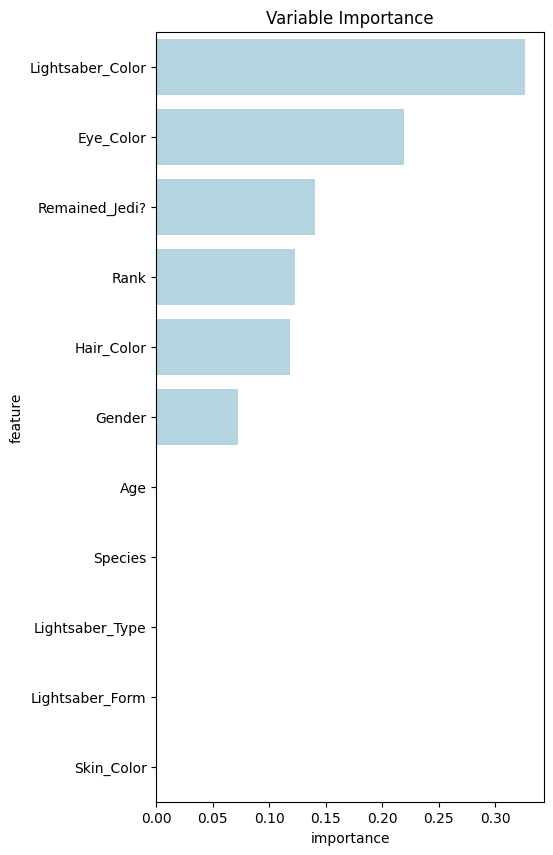

In [ ]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

What this is telling us is how much influence these features have on our y, or the chances of survival until the Battle of Yavin. We can see that lightsaber color has the biggest influence, but if we take into account of Star Wars lore, blue and green are the most common Jedi lightsaber colors, while red is for Sith/Dark Jedi/Inquisitors.

# Clustering Section

# Preprocess Data for Clustering

In [ ]:
# drop unnecessary columns
df.drop(['Name'], axis=1, inplace=True)
# convert Jedi status and gender variables to numerical
df['Remained_Jedi?'] = df['Remained_Jedi?'].apply(lambda x: 1 if x == 'No' else 0)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

df.head()

,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,0,1,900,Unknown,Grand Master,Green,Hazel,Gray,Single blade,Ataru,Green,1
1,0,0,91,Human,Master,Blue,Blue,Silver,Single blade,Ataru,Light,1
2,0,1,57,Human,Master,Blue,Blue-Gray,White,Single blade,Soresu,Fair,1
3,0,1,Unknown,Human,Master,Green,Brown,Black,Single blade,Unknown,Dark,0
4,0,1,23,Human,Knight,Blue,Green,Red,Split blade,Shii-Cho,Light,0


Instead of going the simpler route of creating two separate dataframes, I decided that once finished with the tree, I would rerun the beginning and jump to here. That is why this code is here and might seem out of place, but it is necessary to create my clusters.

In [ ]:
df.head()

,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,0,1,21,28,0,3,8,9,4,0,12,1
1,0,0,17,8,3,0,1,14,4,0,13,1
2,0,1,16,8,3,0,3,17,4,10,9,1
3,0,1,22,8,3,3,5,1,4,11,6,0
4,0,1,1,8,2,0,7,13,5,9,13,0


# Data Standardization

In [ ]:
#Standardize Data
dfcolumns = df.columns.values.tolist()

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=dfcolumns)


df_scaled.head()

,Remained_Jedi?,Gender,Age,Species,Rank,Lightsaber_Color,Eye_Color,Hair_Color,Lightsaber_Type,Lightsaber_Form,Skin_Color,Alive_After_Battle_of_Yavin?
0,-0.989949,0.659380,0.352295,1.492215,-2.136830,-0.780869,-0.262965,-0.050641,-0.004297,-2.716560,-0.175794,0.858395
1,-0.989949,-1.516575,-0.281836,-0.697989,-0.328743,-1.747194,-1.126637,0.813748,-0.004297,-2.716560,0.013376,0.858395
2,-0.989949,0.659380,-0.440368,-0.697989,-0.328743,-1.747194,-0.879874,1.332382,-0.004297,0.235574,-0.743304,0.858395
3,-0.989949,0.659380,0.510827,-0.697989,-0.328743,-0.780869,-0.633110,-1.433664,-0.004297,0.530788,-1.310813,-1.164965
4,-0.989949,0.659380,-2.818357,-0.697989,-0.931439,-1.747194,-0.386347,0.640870,0.421133,-0.059639,0.013376,-1.164965


# Number of Clusters

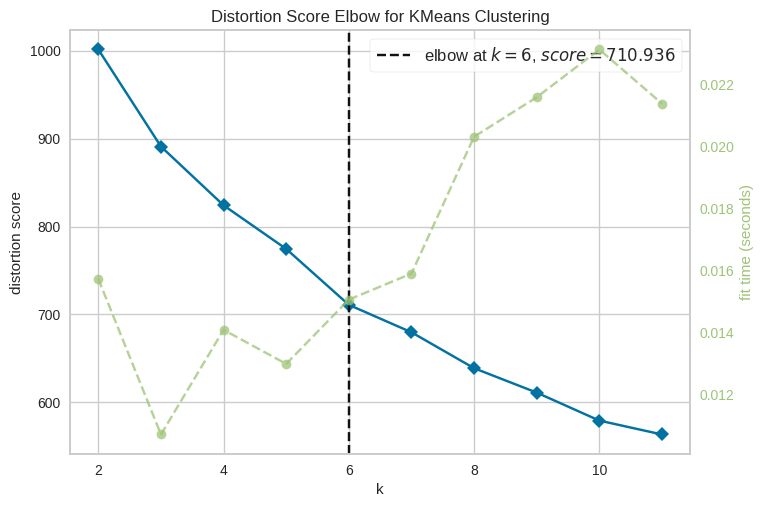

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# set the model type to k-means
model = KMeans()

# generate an elbow plot for k = 2 to 12 clusters using the scaled data
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df_scaled)
visualizer.show()

# Create Clusters & Begin Profiling

In [ ]:
# Create an instance of KMeans with the desired value of k and fit to the scaled data
kmeans = KMeans(n_clusters=5, random_state=904)
kmclus=kmeans.fit(df_scaled)

clusters = kmeans.fit_predict(df_scaled)

#append cluster to original data
df['cluster']=clusters

df.info()

# Evaluate cluster sizes to insure that they are similar
print(df['cluster'].value_counts())

# Examine the means of each variable by cluster
df_desc = df.groupby('cluster').mean()
print(df_desc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Remained_Jedi?                99 non-null     int64
 1   Gender                        99 non-null     int64
 2   Age                           99 non-null     int64
 3   Species                       99 non-null     int64
 4   Rank                          99 non-null     int64
 5   Lightsaber_Color              99 non-null     int64
 6   Eye_Color                     99 non-null     int64
 7   Hair_Color                    99 non-null     int64
 8   Lightsaber_Type               99 non-null     int64
 9   Lightsaber_Form               99 non-null     int64
 10  Skin_Color                    99 non-null     int64
 11  Alive_After_Battle_of_Yavin?  99 non-null     int64
 12  cluster                       99 non-null     int32
dtypes: int32(1), int64(12)
memory usage: 

## Cluster 0 - Fallen Faith

This cluster is made up of force-sensitives that have all fallen to the dark side. Their average rank before Order 66 was Padawan, so that must mean that the Inquisitors make up a major chunk of this cluster. All of their lighsaber colors are red. Unfortunately for them, they have a higher tendency to meet their demise before the Battle of Yavin.

## Cluster 1 - Unknown Ualan

More than half of this cluster gave up their Jedi ways. Was this out of survival? Probably. This cluster also consisted of Padawans, but instead of falling to the dark side, they just went into hiding. This cluster also has pale skin; not sure how helpful this is but there it is. They hid so well that their lightsaber colors and lightsaber forms are unknown. This secrecy seemed to be successful as this cluster has the highest survivability rate.

## Cluster 2 - Fifty Forrest

A bit over half of this cluster gave up their Jedi ways. This has significance because this cluster is made up of Jedi Masters. This group consists of usually humans, with varying blue eyes, varying dark hair, and light skin. Their lightsaber forms are a mix of Shii-Cho and Soresu. These are known for their strong defenses, so these survivors prized defense more than offense. Exactly half of the Order 66 survivors live to see the Battle of Yavin.

## Cluster 3 - Empowering Eden

This cluster is made up of mainly female survivors, which was already not too much in the first place. The way they survived after Order 66 was to give up their Jedi ways. This cluster is in their late 30s and were Jedi Knights before they were hunted. Most have some type of blue eyes and more of them have blue hair. This group prefers to use dual wield and has around a 50% chance of surviving until the Battle of Yavin.

## Cluster 4 - Committed Cody

This cluster has the highest number of survivors that stuck to their Jedi ways. Unfortunately, this meant they carried the biggest targets on their back from the Empire. They have the highest death rates, as they were hunted by Vader and his Inquisitors. This cluster is a mix of Jedi Knights and Masters, so they tend to be on the older side, which explains them having gray hair. They have a variation of blue colored lightsabers and wield single bladed lightsabers. These survivors tend to have green or hazel eyes.

# Thanks for Reading!

I had a lot of fun doing research for this project and I hope you enjoyed my project as well! I will attach the dictionary and dataset in my GitHub so you can go through it yourself or even add on more than what I targeted for each survivor.